**IMPORT LIBRARIES**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from collections import Counter
import re
from textblob import TextBlob
from datetime import datetime
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier
import joblib
import os
from functools import lru_cache
import logging

**Step 1: Exploratory Data Analysis (EDA)**

In [2]:
# Initialize logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    filename='review_analysis.log'
)
logger = logging.getLogger(__name__)

In [3]:
# Load data with path validation
DATA_PATH = os.path.join('data', 'Reviews.csv')
if not os.path.exists(DATA_PATH):
    logger.error("Dataset not found")
    raise FileNotFoundError(f"Dataset not found at {DATA_PATH}")

df = pd.read_csv(DATA_PATH)
logger.info("Dataset loaded successfully")

In [4]:
# EDA Code
print("Dataset Shape:", df.shape)
df.info()
display(df.head())

Dataset Shape: (568454, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568428 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [5]:
# Check for missing values
print("\nMissing values:\n", df.isnull().sum())
df = df.dropna(subset=['Text'])


Missing values:
 Id                         0
ProductId                  0
UserId                     0
ProfileName               26
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64


In [6]:
# Add review length column
df['ReviewLength'] = df['Text'].apply(lambda x: len(str(x).split()))

C:\Users\sunil\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


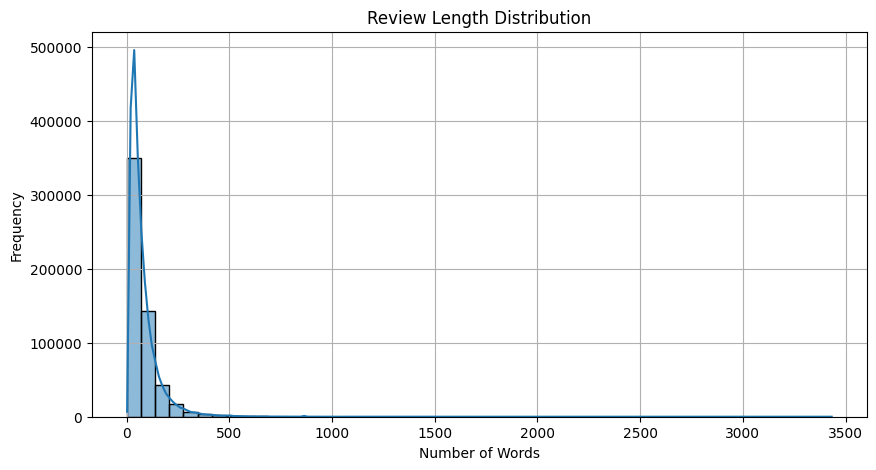

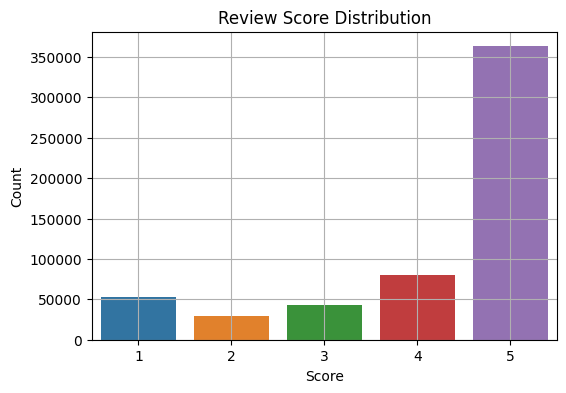

In [7]:
plt.figure(figsize=(10, 5))
sns.histplot(df['ReviewLength'], bins=50, kde=True)
plt.title("Review Length Distribution")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

plt.figure(figsize=(6, 4))
sns.countplot(x='Score', data=df)
plt.title("Review Score Distribution")
plt.xlabel("Score")
plt.ylabel("Count")
plt.grid(True)
plt.show()

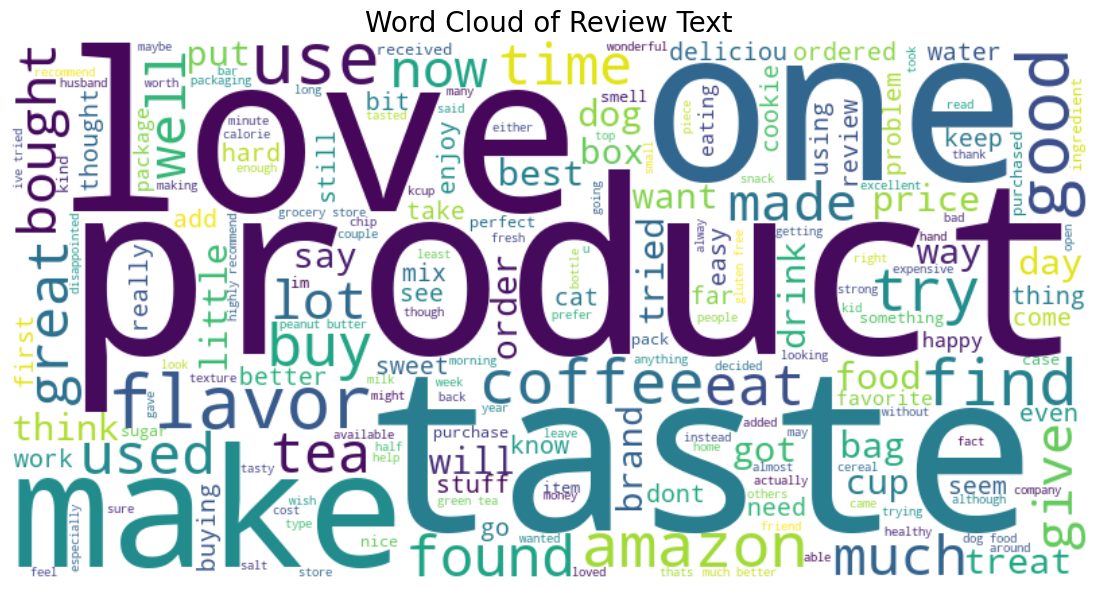

In [8]:
# Generate Word Cloud
text_corpus = " ".join(str(review) for review in df['Text'])
text_corpus = re.sub(r'[^A-Za-z\s]', '', text_corpus.lower())

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_corpus)
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Review Text", fontsize=20)
plt.show()

In [ ]:
# Most common words
nltk.download('punkt')
tokens = nltk.word_tokenize(text_corpus)
word_freq = Counter(tokens)
print("\nTop 20 Most Common Words:")
print(word_freq.most_common(20))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sunil\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!



Top 20 Most Common Words:
[('the', 1865718), ('i', 1494997), ('and', 1278120), ('a', 1218101), ('to', 1011877), ('it', 915067), ('of', 800666), ('is', 732252), ('this', 669458), ('for', 550584), ('in', 543233), ('my', 462173), ('that', 430038), ('but', 370200), ('with', 351804), ('have', 344463), ('not', 340889), ('you', 329444), ('are', 318167), ('was', 314903)]


**TEXT PREPROCESSING**

In [ ]:
nltk.download(['stopwords', 'wordnet', 'omw-1.4'])
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

@lru_cache(maxsize=1000)  
def preprocess_text(text):
    """Enhanced preprocessing function"""
    text = str(text).lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)  
    text = re.sub(r'\@\w+|\#\w+', '', text)  
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens 
              if word not in stop_words and len(word) > 2]  
    return " ".join(tokens)

df['CleanedText'] = df['Text'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sunil\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sunil\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\sunil\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


**SENTIMENT ANALYSIS MODEL [Logistic Regression]**

In [ ]:
def get_sentiment_label(text):
    polarity = TextBlob(text).sentiment.polarity
    if polarity > 0.1:
        return "Positive"
    elif polarity < -0.1:
        return "Negative"
    else:
        return "Neutral"

df['Sentiment'] = df['CleanedText'].apply(get_sentiment_label)

In [ ]:
# Prepare data
X_sent = df['CleanedText']
y_sent = df['Sentiment']

In [ ]:
# Split data
X_train_sent, X_test_sent, y_train_sent, y_test_sent = train_test_split(
    X_sent, y_sent, test_size=0.2, random_state=42, stratify=y_sent
)

In [ ]:
# Added class weight handling
classes = np.unique(y_train_sent)
weights = compute_class_weight('balanced', classes=classes, y=y_train_sent)
class_weights = dict(zip(classes, weights))

In [ ]:
# Pipeline with added class weights
sentiment_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2), stop_words='english')),
    ('clf', LogisticRegression(max_iter=1000, solver='lbfgs', multi_class='auto', class_weight=class_weights))
])

In [ ]:
# Train model
sentiment_pipeline.fit(X_train_sent, y_train_sent)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=5000, ngram_range=(1, 2),
                                 stop_words='english')),
                ('clf',
                 LogisticRegression(class_weight={'Negative': 6.737529075366313,
                                                  'Neutral': 1.7940642728083256,
                                                  'Positive': 0.435884828095197},
                                    max_iter=1000))])

In [ ]:
# Evaluate
y_pred_sent = sentiment_pipeline.predict(X_test_sent)
print("📊 Sentiment Classification Report:\n")
print(classification_report(y_test_sent, y_pred_sent))
print("✅ Accuracy:", accuracy_score(y_test_sent, y_pred_sent))

📊 Sentiment Classification Report:

              precision    recall  f1-score   support

    Negative       0.68      0.89      0.77      5625
     Neutral       0.68      0.85      0.75     21123
    Positive       0.99      0.90      0.94     86943

    accuracy                           0.89    113691
   macro avg       0.78      0.88      0.82    113691
weighted avg       0.91      0.89      0.90    113691

✅ Accuracy: 0.8947410085231021


In [ ]:
# Cross-validation
cv_scores = cross_val_score(sentiment_pipeline, X_sent, y_sent, cv=3, scoring='f1_weighted')
print(f"🔁 Cross-validated F1: {np.mean(cv_scores):.3f} ± {np.std(cv_scores):.3f}")

🔁 Cross-validated F1: 0.899 ± 0.001


In [ ]:
# Save model with error handling
try:
    joblib.dump(sentiment_pipeline, 'models/sentiment_model.pkl')
    logger.info("Sentiment model saved")
except Exception as e:
    logger.error(f"Failed to save sentiment model: {str(e)}")
    raise

**REVIEW TYPE MODEL [Multinomial Naive Bayes]**

In [ ]:
query_keywords = ["how", "what", "can i", "do you", "is it", "where", "why", "who", "when", "which", "?", "help", "details", "info", "explain", "guide", "instruction",
                  "manual", "procedure", "step"]

suggestion_keywords = ["should", "recommend", "wish", "could", "prefer", "better if", "improve", "suggest", "would like","could be better", "add", "feature", "enhance", "update",
                       "upgrade", "change", "make it", "option", "more", "less"]

complaint_keywords = ["bad", "poor", "not working", "broken", "hate", "worst", "slow", "error", "issue", "does not","failed", "problem", "garbage", "terrible", "refund", "return",
                      "disappointed", "crash", "useless", "stopped"]

In [ ]:
# Save keywords for front-end
keyword_dict = {
    'query': query_keywords,
    'suggestion': suggestion_keywords,
    'complaint': complaint_keywords
}
joblib.dump(keyword_dict, 'models/reviewtype_keywords.pkl')

def classify_review_type(text):
    text = text.lower()
    if any(kw in text for kw in query_keywords):
        return "Query"
    elif any(kw in text for kw in suggestion_keywords):
        return "Suggestion"
    elif any(kw in text for kw in complaint_keywords):
        return "Complaint"
    else:
        return "Feedback"

df['ReviewType'] = df['CleanedText'].apply(classify_review_type)

In [ ]:
# Prepare data
X_type = df['CleanedText']
y_type = df['ReviewType']

In [ ]:
# Split data
X_train_type, X_test_type, y_train_type, y_test_type = train_test_split(
    X_type, y_type, test_size=0.2, random_state=42, stratify=y_type
)

In [ ]:
# Pipeline
review_type_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2), stop_words='english')),
    ('clf', MultinomialNB())
])

In [ ]:
# Train model
review_type_pipeline.fit(X_train_type, y_train_type)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=5000, ngram_range=(1, 2),
                                 stop_words='english')),
                ('clf', MultinomialNB())])

In [ ]:
# Evaluate
y_pred_type = review_type_pipeline.predict(X_test_type)
print("📊 Review Type Classification Report:\n")
print(classification_report(y_test_type, y_pred_type))
print("✅ Accuracy:", accuracy_score(y_test_type, y_pred_type))

📊 Review Type Classification Report:

              precision    recall  f1-score   support

   Complaint       0.71      0.14      0.23      8341
    Feedback       0.76      0.94      0.84     50357
       Query       0.55      0.49      0.52     24850
  Suggestion       0.69      0.64      0.66     30143

    accuracy                           0.70    113691
   macro avg       0.68      0.55      0.56    113691
weighted avg       0.69      0.70      0.68    113691

✅ Accuracy: 0.7022367645635978


In [ ]:
# Save model
try:
    joblib.dump(review_type_pipeline, 'models/reviewtype_model.pkl')
    logger.info("Review type model saved")
except Exception as e:
    logger.error(f"Failed to save review type model: {str(e)}")
    raise

**PRODUCT CATEGORY MODEL [Random Forest Classifier]**

In [ ]:
# LDA code
tfidf = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1, 2))
X_tfidf = tfidf.fit_transform(df['CleanedText'])

lda_model = LatentDirichletAllocation(n_components=10, random_state=42)
lda_topics = lda_model.fit_transform(X_tfidf)
df['Topic'] = lda_topics.argmax(axis=1)

In [ ]:
# Save vectorizer
try:
    joblib.dump(tfidf, "models/vectorizer.pkl")
    logger.info("TF-IDF vectorizer saved")
except Exception as e:
    logger.error(f"Failed to save vectorizer: {str(e)}")
    raise

In [ ]:
# Print topics
def print_topic_keywords(model, vectorizer, top_n=10):
    keywords = []
    feature_names = vectorizer.get_feature_names_out()
    for topic_idx, topic in enumerate(model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-top_n - 1:-1]]
        keywords.append(top_words)
        print(f"🔹 Topic {topic_idx}: {', '.join(top_words)}")
    return keywords

topic_keywords = print_topic_keywords(lda_model, tfidf)

🔹 Topic 0: snack, bar, cooky, great, good, love, taste, cereal, peanut, eat
🔹 Topic 1: sauce, make, use, soup, good, like, great, taste, flavor, mix
🔹 Topic 2: coffee, cup, flavor, like, strong, taste, roast, kcups, blend, good
🔹 Topic 3: chip, taste, flavor, salt, like, drink, sugar, water, good, coconut
🔹 Topic 4: dog, food, cat, treat, love, dog love, like, eat, dog food, chew
🔹 Topic 5: product, box, order, arrived, ordered, received, amazon, bag, gift, item
🔹 Topic 6: price, amazon, store, great, local, buy, grocery, product, love, grocery store
🔹 Topic 7: product, baby, work, water, use, like, hair, bottle, day, great
🔹 Topic 8: chocolate, taste, like, flavor, candy, bar, good, sweet, cocoa, really
🔹 Topic 9: tea, green, green tea, taste, flavor, drink, popcorn, like, good, bag


In [ ]:
# Manual mapping
topic_to_category = {
    0: "Pet Supplies",
    1: "Tea & Beverages",
    2: "Snack Bars & Cereals",
    3: "Delivery Experience",
    4: "Pet Food",
    5: "Chips & Salty Snacks",
    6: "Sauces & Meal Starters",
    7: "Shopping & Pricing",
    8: "Sweets & Personal Use",
    9: "Coffee & Pods"
}

In [ ]:
# Save topic mapping
try:
    joblib.dump(topic_to_category, 'models/topic_category_mapping.pkl')
    logger.info("Topic mapping saved")
except Exception as e:
    logger.error(f"Failed to save topic mapping: {str(e)}")
    raise

df['ProductCategory'] = df['Topic'].map(topic_to_category)
df.drop(columns=['Topic'], inplace=True)

In [ ]:
# Prepare data
X_cat = df['CleanedText']
y_cat = df['ProductCategory']

In [ ]:
# Split data
X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(
    X_cat, y_cat, test_size=0.2, random_state=42, stratify=y_cat
)

In [ ]:
# Original pipeline preserved
product_category_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2), stop_words='english')),
    ('clf', RandomForestClassifier(n_estimators=150, random_state=42))
])

In [ ]:
# Train model
product_category_pipeline.fit(X_train_cat, y_train_cat)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=5000, ngram_range=(1, 2),
                                 stop_words='english')),
                ('clf',
                 RandomForestClassifier(n_estimators=150, random_state=42))])

In [ ]:
# Evaluate
y_pred_cat = product_category_pipeline.predict(X_test_cat)
print("📊 Product Category Classification Report:\n")
print(classification_report(y_test_cat, y_pred_cat))
print("✅ Accuracy:", accuracy_score(y_test_cat, y_pred_cat))

📊 Product Category Classification Report:

                        precision    recall  f1-score   support

  Chips & Salty Snacks       0.80      0.78      0.79     11951
         Coffee & Pods       0.88      0.91      0.90      8503
   Delivery Experience       0.87      0.79      0.83      9659
              Pet Food       0.94      0.97      0.95     14911
          Pet Supplies       0.82      0.87      0.84     13695
Sauces & Meal Starters       0.78      0.75      0.76      8487
    Shopping & Pricing       0.87      0.75      0.81     10046
  Snack Bars & Cereals       0.90      0.97      0.93     12053
 Sweets & Personal Use       0.79      0.73      0.76     10465
       Tea & Beverages       0.79      0.86      0.83     13921

              accuracy                           0.85    113691
             macro avg       0.84      0.84      0.84    113691
          weighted avg       0.85      0.85      0.85    113691

✅ Accuracy: 0.8468216481515687


In [ ]:
# Save model
try:
    joblib.dump(product_category_pipeline, 'models/department_model.pkl')
    logger.info("Product category model saved")
except Exception as e:
    logger.error(f"Failed to save product category model: {str(e)}")
    raise

**TRENDINESS MODEL [XGBoost Classifier]**

In [ ]:
df['ReviewTime'] = pd.to_datetime(df['Time'], unit='s')
df['Week'] = df['ReviewTime'].dt.to_period('W').astype(str)

weekly_counts = df.groupby(['ProductId', 'Week']).size().reset_index(name='Count')

def detect_spikes(group):
    group['RollingAvg'] = group['Count'].rolling(window=3, min_periods=1).mean()
    group['ZScore'] = (group['Count'] - group['RollingAvg']) / (group['RollingAvg'].std() + 1e-5)
    return group

weekly_counts = weekly_counts.groupby('ProductId').apply(detect_spikes).reset_index(drop=True)
df = df.merge(weekly_counts[['ProductId', 'Week', 'ZScore']], on=['ProductId', 'Week'], how='left')
df['Trendiness'] = df['ZScore'].apply(lambda z: 'Trendy' if z > 1.5 else 'Non-Trendy')
df.drop(columns=['Week', 'ZScore'], inplace=True)

C:\Users\sunil\AppData\Local\Temp\ipykernel_15028\1325923251.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weekly_counts = weekly_counts.groupby('ProductId').apply(detect_spikes).reset_index(drop=True)


In [ ]:
# Prepare data
X_trend = df['CleanedText']
y_trend = df['Trendiness']

In [ ]:
# Split data
X_train_trend, X_test_trend, y_train_trend, y_test_trend = train_test_split(
    X_trend, y_trend, test_size=0.2, random_state=42, stratify=y_trend
)

In [ ]:
# Label encoding preserved
le = LabelEncoder()
y_train_trend_encoded = le.fit_transform(y_train_trend)
y_test_trend_encoded = le.transform(y_test_trend)

In [ ]:
trend_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2), stop_words='english')),
    ('clf', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42))
])

C:\Users\sunil\AppData\Roaming\Python\Python311\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


In [ ]:
# Train model
trend_pipeline.fit(X_train_trend, y_train_trend_encoded)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=5000, ngram_range=(1, 2),
                                 stop_words='english')),
                ('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='mlogloss',
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=42, ...))])

In [ ]:
# Evaluate
y_pred_trend_encoded = trend_pipeline.predict(X_test_trend)
y_pred_trend = le.inverse_transform(y_pred_trend_encoded)

print("📊 Trendiness Classification Report:\n")
print(classification_report(y_test_trend, y_pred_trend))
print("✅ Accuracy:", accuracy_score(y_test_trend, y_pred_trend))

📊 Trendiness Classification Report:

              precision    recall  f1-score   support

  Non-Trendy       0.87      1.00      0.93     98272
      Trendy       0.92      0.05      0.10     15419

    accuracy                           0.87    113691
   macro avg       0.90      0.53      0.52    113691
weighted avg       0.88      0.87      0.82    113691

✅ Accuracy: 0.8709660395281948


In [ ]:
# Save model and encoder
try:
    joblib.dump(trend_pipeline, 'models/trend_model.pkl')
    joblib.dump(le, 'models/trend_label_encoder.pkl')
    logger.info("Trendiness model and encoder saved")
except Exception as e:
    logger.error(f"Failed to save trendiness model: {str(e)}")
    raise

**VISUALIZATIONS**

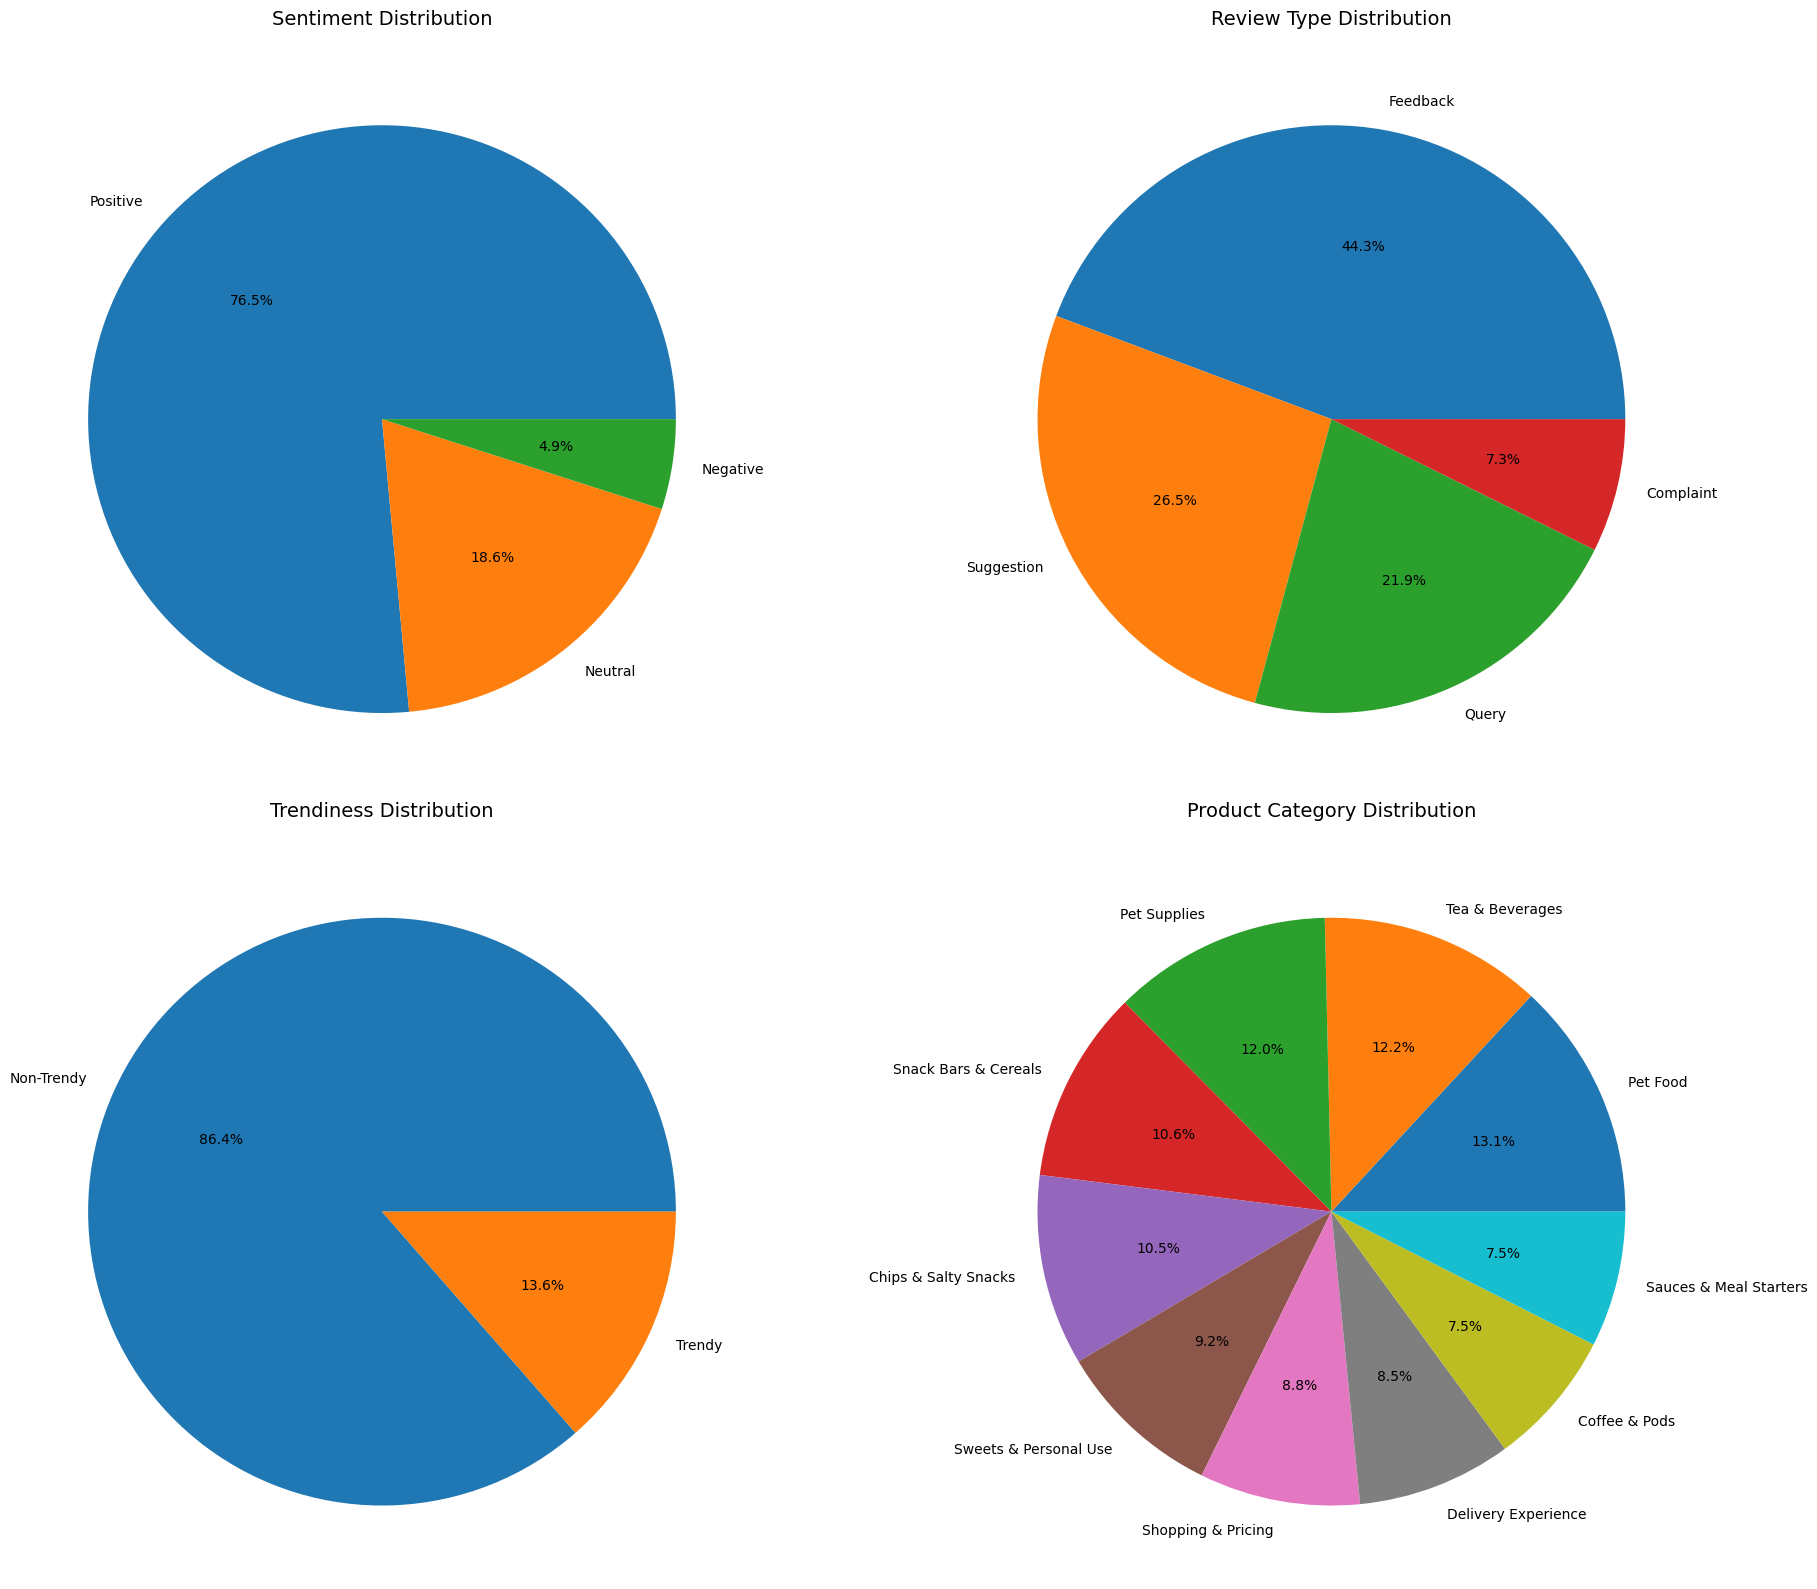

In [ ]:
plt.figure(figsize=(20, 16))

plt.subplot(2, 2, 1)
sentiment_counts = df['Sentiment'].value_counts()
plt.pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%')
plt.title('Sentiment Distribution', fontsize=14, pad=20)

plt.subplot(2, 2, 2)
review_type_counts = df['ReviewType'].value_counts()
plt.pie(review_type_counts.values, labels=review_type_counts.index, autopct='%1.1f%%')
plt.title('Review Type Distribution', fontsize=14, pad=20)

plt.subplot(2, 2, 3)
trendiness_counts = df['Trendiness'].value_counts()
plt.pie(trendiness_counts.values, labels=trendiness_counts.index, autopct='%1.1f%%')
plt.title('Trendiness Distribution', fontsize=14, pad=20)

plt.subplot(2, 2, 4)
category_counts = df['ProductCategory'].value_counts()
plt.pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%')
plt.title('Product Category Distribution', fontsize=14, pad=20)

plt.tight_layout()
plt.show()

**MODEL COMPARISON**

In [ ]:
model_metrics = pd.DataFrame({
    'Model (Algorithm)': [
        'Sentiment (LogReg)',
        'Review Type (NaiveBayes)',
        'Product Category (RF)',
        'Trendiness (XGBoost)'
    ],
    'Accuracy': [
        accuracy_score(y_test_sent, y_pred_sent),
        accuracy_score(y_test_type, y_pred_type),
        accuracy_score(y_test_cat, y_pred_cat),
        accuracy_score(y_test_trend, y_pred_trend)
    ],
    'Weighted F1': [
        f1_score(y_test_sent, y_pred_sent, average='weighted'),
        f1_score(y_test_type, y_pred_type, average='weighted'),
        f1_score(y_test_cat, y_pred_cat, average='weighted'),
        f1_score(y_test_trend, y_pred_trend, average='weighted')
    ],
    'Weighted Precision': [
        precision_score(y_test_sent, y_pred_sent, average='weighted'),
        precision_score(y_test_type, y_pred_type, average='weighted'),
        precision_score(y_test_cat, y_pred_cat, average='weighted'),
        precision_score(y_test_trend, y_pred_trend, average='weighted')
    ]
})

print("📊 Model Performance Comparison:\n")
display(model_metrics.style.format({
    'Accuracy': '{:.3f}',
    'Weighted F1': '{:.3f}',
    'Weighted Precision': '{:.3f}'
}).background_gradient(cmap='Blues'))

📊 Model Performance Comparison:



,Model (Algorithm),Accuracy,Weighted F1,Weighted Precision
0,Sentiment (LogReg),0.895,0.901,0.915
1,Review Type (NaiveBayes),0.702,0.679,0.693
2,Product Category (RF),0.847,0.846,0.847
3,Trendiness (XGBoost),0.871,0.818,0.878


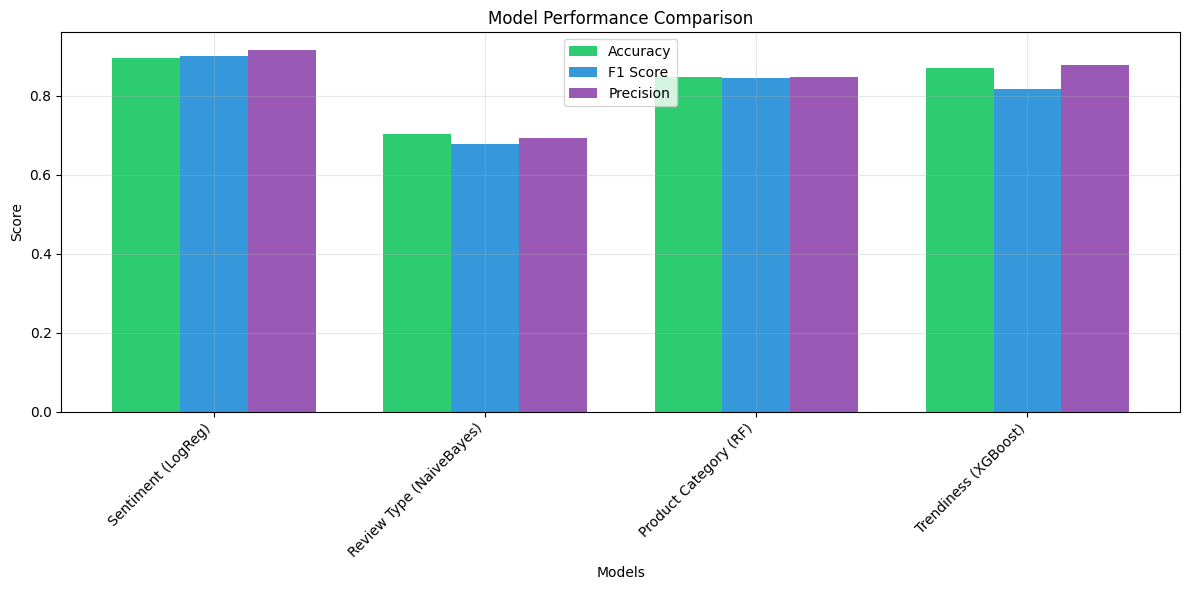

In [ ]:
plt.figure(figsize=(12, 6))
x = np.arange(len(model_metrics['Model (Algorithm)']))
width = 0.25

plt.bar(x - width, model_metrics['Accuracy'], width, label='Accuracy', color='#2ecc71')
plt.bar(x, model_metrics['Weighted F1'], width, label='F1 Score', color='#3498db')
plt.bar(x + width, model_metrics['Weighted Precision'], width, label='Precision', color='#9b59b6')

plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks(x, model_metrics['Model (Algorithm)'], rotation=45, ha='right')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**FINAL SAVE & STREAMLIT PREP**

In [ ]:
# Save dataset with versioning
VERSION = datetime.now().strftime("%Y%m%d_%H%M")
try:
    df.to_csv(f'data/amazon_reviews_cleaned_{VERSION}.csv', index=False)
    logger.info("Final dataset saved")
except Exception as e:
    logger.error(f"Failed to save final dataset: {str(e)}")
    raise

In [ ]:
# Unified prediction function
def predict_all_models(text, models):
    """Predict all categories for a single review"""
    cleaned = preprocess_text(text)
    
    return {
        'sentiment': models['sentiment'].predict([cleaned])[0],
        'review_type': models['review_type'].predict([cleaned])[0],
        'product_category': models['product_category'].predict([cleaned])[0],
        'trendiness': models['trend_label_encoder'].inverse_transform(
            models['trendiness'].predict([cleaned])
        )[0],
        'cleaned_text': cleaned
    }

In [ ]:
logger.info("Pipeline completed successfully")
print("\n🚀 All models trained and saved successfully!")


🚀 All models trained and saved successfully!
